In [1]:
# %load ~/my_imports
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re

pd.set_option("display.max_rows", 1000)
pd.set_option("max_columns", 100)
pd.set_option("max_colwidth",10000)
import requests 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [23]:
try:
    keras.backend.clear_session() # 把舊的 Graph 清掉
except:
    pass

In [24]:

# 資料路徑
DATASET_PATH  = 'ml100-03-final/image_data'

# 影像大小
IMAGE_SIZE = (240, 240)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 32

# 凍結網路層數
FREEZE_LAYERS = -2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'ml100-03-final/model-resnet50-basic.h5'

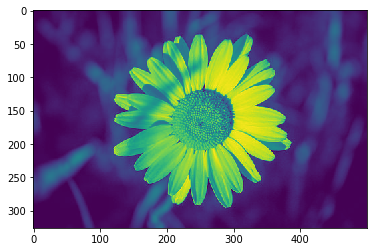

In [25]:
import numpy as np
import cv2

# Load an color image in grayscale
img = cv2.imread(DATASET_PATH + '/train/daisy/0a3e7507742e246b3a2e630debbbaf99.jpg',0)
plt.imshow(img)

In [26]:
# from tensorflow.python.keras import backend as K
# from tensorflow.python.keras.models import Model
import keras
# from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


In [27]:
import sys
from PIL import Image
import PIL
# sys.modules['Image'] = Image 
# print(Image.__file__)

In [28]:
# 透過 data augmentation 產生訓練與驗證用的影像資料

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                  validation_split=0.2)

train_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,
                                                    subset='training'
                                                  )

validation_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,
                                                    subset='validation'
                                                  )

Found 2260 images belonging to 5 classes.
Found 563 images belonging to 5 classes.


In [29]:
# next(train_generator)

In [30]:
# 輸出各類別的索引值
for cls, idx in train_generator.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [31]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(DATASET_PATH + '/test/',
                                                target_size=IMAGE_SIZE,
                                                color_mode="rgb",
                                                batch_size=1,
                                                class_mode=None,
                                                shuffle=False,
                                                seed=42)



Found 2000 images belonging to 1 classes.


In [32]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

70 17


In [33]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers

net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

/Users/ttyoung/anaconda3/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [34]:
import keras

In [35]:
x = net.output
x = keras.layers.Flatten()(x)

# 增加 DropOut layer
x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(16,activation='relu')(x)
# x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.Dense(32,activation='relu')(x)
# x = keras.layers.Dropout(0.2)(x)


# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = keras.layers.Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)


In [37]:

# 設定凍結與要進行訓練的網路層
net_final = keras.models.Model(inputs=net.input, outputs=output_layer)

for i,layer in enumerate(net_final.layers):
    print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 pool1_pad
6 max_pooling2d_1
7 res2a_branch2a
8 bn2a_branch2a
9 activation_2
10 res2a_branch2b
11 bn2a_branch2b
12 activation_3
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_1
18 activation_4
19 res2b_branch2a
20 bn2b_branch2a
21 activation_5
22 res2b_branch2b
23 bn2b_branch2b
24 activation_6
25 res2b_branch2c
26 bn2b_branch2c
27 add_2
28 activation_7
29 res2c_branch2a
30 bn2c_branch2a
31 activation_8
32 res2c_branch2b
33 bn2c_branch2b
34 activation_9
35 res2c_branch2c
36 bn2c_branch2c
37 add_3
38 activation_10
39 res3a_branch2a
40 bn3a_branch2a
41 activation_11
42 res3a_branch2b
43 bn3a_branch2b
44 activation_12
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_4
50 activation_13
51 res3b_branch2a
52 bn3b_branch2a
53 activation_14
54 res3b_branch2b
55 bn3b_branch2b
56 activation_15
57 res3b_branch2c
58 bn3b_branch2c
59 add_5
60 activation_16
61 res3c_branch2a
62 bn3c_branch2a

In [38]:
net_final.layers[-2:]

In [39]:
FREEZE_LAYERS = -2
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])


In [40]:
# 輸出整個網路結構
print(net_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 246, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 120, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 120, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [41]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=30, 
                          verbose=1
                          )

In [42]:
# 訓練模型
net_final.fit_generator(train_generator,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = validation_generator,
                        validation_steps = STEP_SIZE_VALID,
                        epochs = NUM_EPOCHS,
                        verbose=1,
                       callbacks=[earlystop]
                       )

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Epoch 1/20
70/70 [==============================] - 712s 10s/step - loss: 1.8750 - accuracy: 0.5763 - val_loss: 1.9653 - val_accuracy: 0.6415
Epoch 2/20
70/70 [==============================] - 703s 10s/step - loss: 1.0491 - accuracy: 0.7487 - val_loss: 0.7049 - val_accuracy: 0.7439
Epoch 3/20
70/70 [==============================] - 716s 10s/step - loss: 0.9655 - accuracy: 0.7783 - val_loss: 1.6640 - val_accuracy: 0.7119
Epoch 4/20
70/70 [==============================] - 718s 10s/step - loss: 0.8583 - accuracy: 0.7926 - val_loss: 1.8162 - val_accuracy: 0.7250
Epoch 5/20
70/70 [==============================] - 718s 10s/step - loss: 0.8039 - accuracy: 0.8173 - val_loss: 0.8788 - val_accuracy: 0.7439
Epoch 6/20
70/70 [==============================] - 720s 10s/step - loss: 0.7612 - accuracy: 0.8362 - val_loss: 1.2925 - val_accuracy: 0.7232
Epoch 7/20
70/70 [==============================] - 720s 10s/step - loss: 0.7287 - accuracy: 0.8380 - val_loss: 2.0023 - val_accuracy: 0.7269
Epoch 

In [44]:
score = net_final.evaluate(validation_generator, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Test loss: 1.0594477653503418
Test accuracy: 0.7708703279495239


In [46]:
score = net_final.evaluate_generator(generator=validation_generator,
steps=STEP_SIZE_VALID)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.3703058958053589
Val accuracy: 0.7628676295280457


## predict

In [48]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=net_final.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

2000/2000 [==============================] - 282s 141ms/step


In [49]:
predicted_class_indices=np.argmax(pred,axis=1)

In [53]:
labels

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [55]:
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}

In [50]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in labels]

In [61]:
filenames=test_generator.filenames
results=pd.DataFrame({"id":filenames,
                      "prediction":predictions})
results['flower_class'] = results.prediction.apply(lambda x: flower_mapping[x])
results['id'] = results.id.apply(lambda x: (x.split('/')[1]).replace('.jpg',''))
results.head()

,id,prediction,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,rose,2
1,002c30700185b7971369258b438070d5,tulip,4
2,00852f4f666acecd0c0d140365b42efd,rose,2
3,00c08828fce04e360c732cac01edad9e,tulip,4
4,00d366e7877b6a78b104b57d67b60e6b,tulip,4


In [62]:
results[['id','flower_class']].to_csv("results.csv",index=False)

In [63]:
results.count()

id              2000
prediction      2000
flower_class    2000
dtype: int64

In [108]:
# train_data = pd.read_csv('3rd-ml100marathon-midterm/train_data.csv')
# test_data = pd.read_csv('3rd-ml100marathon-midterm/test_features.csv')

In [64]:
x_batch, y_batch = next(train_generator)

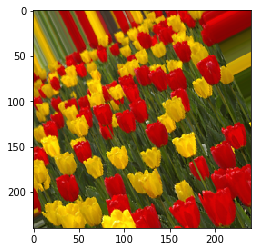

In [69]:
plt.imshow(x_batch.astype("int")[0])

In [73]:
train_datagen_small = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                  validation_split=0.2)

train_generator_small = train_datagen_small.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=(128,128),
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,
                                                    subset='training'
                                                  )

Found 2260 images belonging to 5 classes.


In [74]:
x_batch, y_batch = next(train_generator_small)

In [78]:
train_generator_small.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [77]:
y_batch[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [76]:
train_generator_small.filenames[0]

'daisy/3985ebc9cb201f355617b10d8c822c75.jpg'

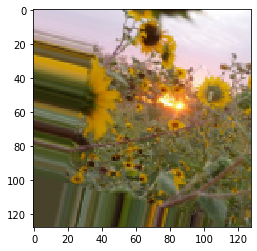

In [75]:
plt.imshow(x_batch.astype("int")[0])

In [110]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np

# 從參數讀取圖檔路徑
# files = sys.argv[1:]

# 載入訓練好的模型
net = load_model('ml100-03-final/model-resnet50-basic.h5')

cls_list = ['cats', 'dogs']

# 辨識每一張圖
for f in files:
    img = image.load_img(f, target_size=(224, 224))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    print(f)
    for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

OSError: SavedModel file does not exist at: model-resnet50-final.h5/{saved_model.pbtxt|saved_model.pb}